# Q&A with RAG using Amazon Bedrock and LangChain

## Overview

Q&A applications powered by LLMs is one of the most prominent and common GenAI use case. These applications can provide detailed and accurate responses to queries about specific source information. These applications are based on technique known as Retrieval Augmented Generation, or RAG. This approach combines the vast knowledge encapsulated in LLMs with the ability to retrieve and incorporate relevant information from external sources. By leveraging RAG, Q&A applications can offer more precise, up-to-date, and context-aware answers than traditional chatbots or standalone LLMs.

In this sample you will learn how to build question-answering application using Amazon Bedrock and LangChain. We will cover following concepts 

• This notebook covers the basic components of building a Q&A application using Amazon Bedrock and LangChain.

• How to use Amazon Bedrock APIs with LangChain

• Different LangChain components for building the chatbot

• LangSmith is introduced as a tool for tracing and debugging the application.


## Architecture

Below is a high-level overview of RAG architecture. 

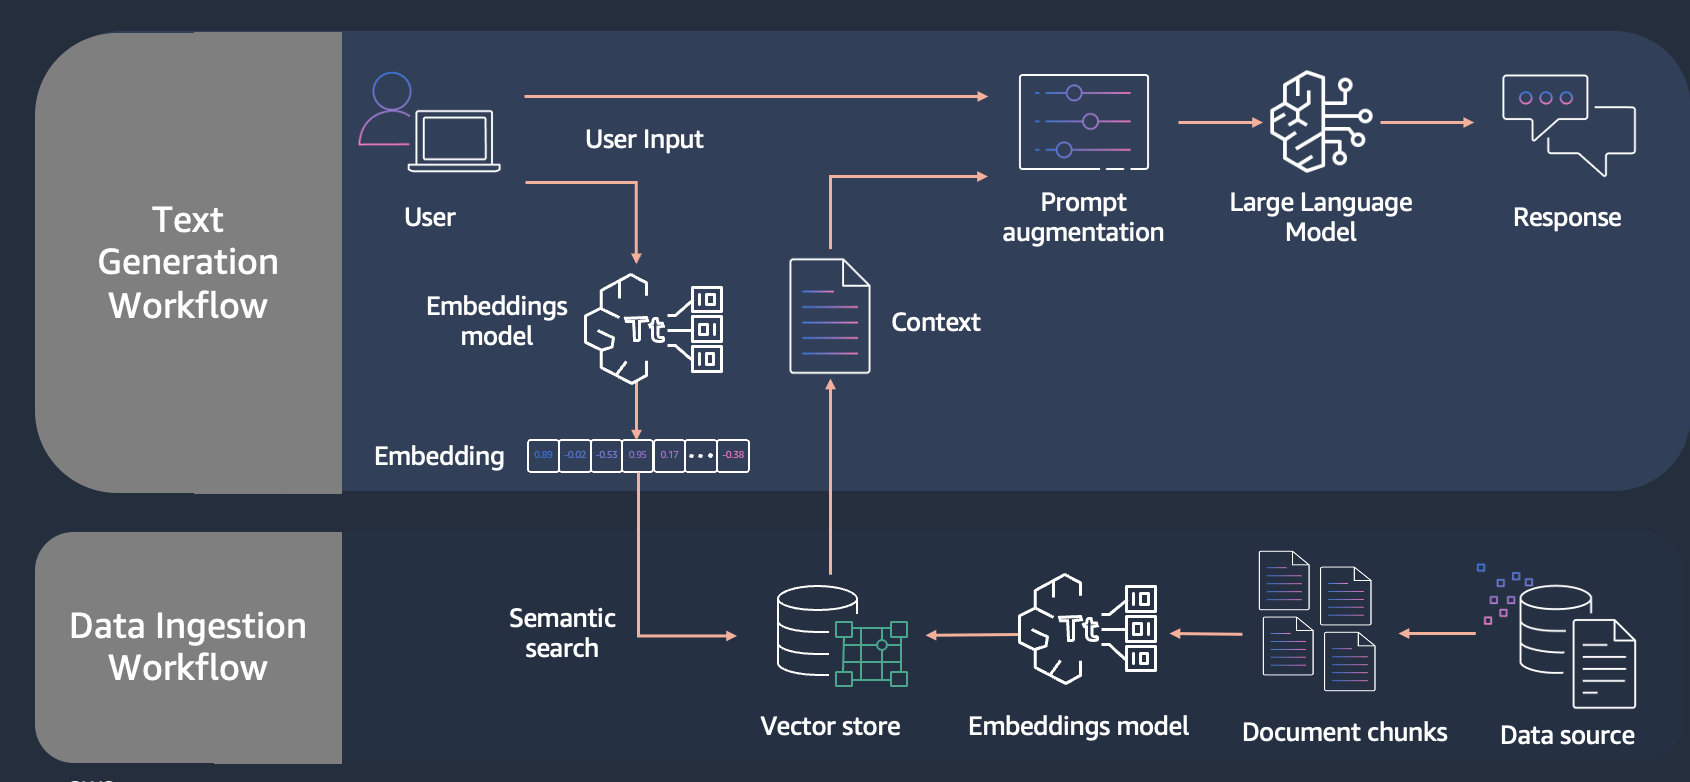

RAG consists of two main components: a retriever and a generator.

- Retriever: The retriever is responsible for retrieving relevant information from text source
- Generator: The generator is an LLM that takes the input query/context and the retrieved information as input and generates the final output text

In this notebook we will be using LangChain and LLMs from Amazon Bedrock to build these components.

### Dependencies

We’ll use Anthropic's Claude 3 Sonnet model from Amazon Bedrock as generation model, Amazon Titan embedding as embeddings and a Chroma vector store in this walkthrough. We will use LangChain as an orchestrator to build this Q&A chatbot. 
We will also use LangSmith for tracing and debugging. 



In [2]:
%pip install --upgrade --quiet  langchain langchain-community langchain_aws langchain-chroma langchainhub bs4 pypdf

Note: you may need to restart the kernel to use updated packages.


## Setup

**Let's first test the basic setup with Amazon Bedrock.**

In [1]:
from langchain_aws import ChatBedrockConverse
import boto3

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")

llm = ChatBedrockConverse(
    client=bedrock_client,
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
)

llm.invoke(input="What is Amazon's doing in the field of generative AI?")

AIMessage(content="Amazon has been actively involved in the development of generative AI technologies through its Amazon Web Services (AWS) cloud computing platform and various research initiatives. Here are some of Amazon's efforts in the field of generative AI:\n\n1. Amazon AI: Amazon has an artificial intelligence research team called Amazon AI that focuses on developing advanced machine learning models, including generative models. They have contributed to areas such as natural language processing, computer vision, and speech recognition.\n\n2. AWS Generative AI services: AWS offers several generative AI services and tools, including:\n   - Amazon CodeWhisperer: A machine learning-powered service that generates code recommendations based on natural language input, helping developers write code more efficiently.\n   - Amazon Polly: A text-to-speech service that uses deep learning to generate natural-sounding speech from text input.\n   - Amazon Transcribe: An automatic speech recogn

Now that we have verified basic setup, let's move on to the next step - building Q&A chatbot.

In [6]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

**Following step is optional**

In [ ]:
# this is required if you want to enable tracing using LangSmith
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Bedrock Q&A chatbot"

## 1. Load Documents

We first need to download sample documents on which we will be building our Q&A. For this sample we are downloading Amazon letter to shareholders.

In [2]:
!mkdir -p ./data

from urllib.request import urlretrieve

urls = [
    "https://s2.q4cdn.com/299287126/files/doc_financials/2023/ar/2022-Shareholder-Letter.pdf",
    "https://s2.q4cdn.com/299287126/files/doc_financials/2022/ar/2021-Shareholder-Letter.pdf",
    "https://s2.q4cdn.com/299287126/files/doc_financials/2021/ar/Amazon-2020-Shareholder-Letter-and-1997-Shareholder-Letter.pdf",
    "https://s2.q4cdn.com/299287126/files/doc_financials/2020/ar/2019-Shareholder-Letter.pdf",
]

filenames = [
    "AMZN-2022-Shareholder-Letter.pdf",
    "AMZN-2021-Shareholder-Letter.pdf",
    "AMZN-2020-Shareholder-Letter.pdf",
    "AMZN-2019-Shareholder-Letter.pdf",
]

data_root = "./data/"

for idx, url in enumerate(urls):
    file_path = data_root + filenames[idx]
    urlretrieve(url, file_path)

LangChain has a few different built-in document [loaders](https://python.langchain.com/v0.2/docs/how_to/document_loader_pdf/) to load pdf document. Below, we'll use pypdf package that reads from a filepath. 

- The loader reads the PDF at the specified path into memory.
- It then extracts text data using the pypdf package.
- Finally, it creates a LangChain Document for each page of the PDF with the page's content and some metadata about where in the document the text came from.

In [3]:
from langchain.document_loaders import PyPDFLoader
import os

data_root = "./data/"
folder_path = data_root
documents = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    loader = PyPDFLoader(file_path)
    # Load the PDF data
    data = loader.load()
    # Add the loaded data to the documents list
    documents.extend(data)

# Print the text of the first page of the first document
if documents:
    print(documents[0].page_content)
else:
    print("No PDF files found in the folder.")

To our shareowners:
In Amazon’s 1997 letter to shareholders, our first, I talked about our hope to create an “enduring franchise,”
one that would reinvent what it means to serve customers by unlocking the internet’s power. I noted that
Amazon had grown from having 158 employees to 614, and that we had surpassed 1.5 million customer
accounts. We had just gone public at a split-adjusted stock price of $1.50 per share. I wrote that it was Day 1.
We’ve come a long way since then, and we are working harder than ever to serve and delight customers.
Last year, we hired 500,000 employees and now directly employ 1.3 million people around the world. We have
more than 200 million Prime members worldwide. More than 1.9 million small and medium-sized businesses
sell in our store, and they make up close to 60% of our retail sales. Customers have connected more than
100 million smart home devices to Alexa. Amazon Web Services serves millions of customers and ended 2020
with a $50 billion annualized r

## 2. Retriever

Lets first look in the chunking process

### 2.1 Retriever - Chunking

When working with large documents or texts, it is often necessary to break them down into smaller, more manageable chunks. This process is known as chunking, and it is particularly useful when dealing with models that have limited context windows or when working with extremely long documents that could overwhelm the model's capabilities.

Here are the steps involved in the chunking process described in the given text:

- Determine the maximum length that the model can handle effeciently and economically

- Decide on the chunk size and overlap. In this example, the text will be split into chunks of 1,000 characters with an overlap of 200 characters between adjacent chunks

- Choose the text splitting method. In this example we are using `RecursiveCharacterTextSplitter`, which recursively splits the document using common separators like newlines until each chunk is of the desired size

**The chunking process helps in several ways:**

- It breaks down large documents into smaller, more manageable pieces that can fit within the context window of models.
- It aids in retrieving only the most relevant portions of the text at runtime, rather than having to process the entire document.
- The overlap between chunks helps to preserve context and ensure that statements are not separated from important related information.
- By following this chunking approach, you can effectively work with large documents while optimizing the performance and accuracy of your models or applications.

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(documents)

In [6]:
len(splits)

211

### 2.2 Retriever - Indexing

The indexing process is an important step in preparing the chunked documents for efficient retrieval and search. It involves creating vector embeddings of each chunk and storing these embeddings in a vector database or vector store. This allows for similarity-based searches, enabling us to find the most relevant chunks for a given query. 

Following steps are important for indexing:

- Obtain the chunked documents - this we have done in the previous step
- Choose an embedding model: Select a suitable embedding model that can convert the text content of each chunk into a high-dimensional vector representation. In this example we are using Amazon titan embedding model - `amazon.titan-embed-text-v1`
- Initialize a vector store: Set up a vector store or vector database that will store the embeddings. LangChain provides several options for vector stores, in this example we are suing local vector store of ChromaDB

In [7]:
from langchain_chroma import Chroma
from langchain_aws.embeddings.bedrock import BedrockEmbeddings

embeddings_model = BedrockEmbeddings(
     client=bedrock_client, model_id="amazon.titan-embed-text-v1"
)
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings_model)

### 2.3 Retriever - Retrieve

Once the indexing process is complete, you can perform similarity-based searches over the indexed chunks.

To retrieve revlevant chunks for a given query you will: 
- Embed the search query using the same embedding model used for indexing
- Define the search logic - LangChain defines a Retriever interface which wraps an index that can return relevant Documents given a string query. The most common type of Retriever is the `VectorStoreRetriever`, which uses the similarity search capabilities of a vector store to facilitate retrieval. 



In [9]:
retriever = vectorstore.as_retriever()
retrieved_docs = retriever.invoke(
    "What is Amazon's doing in the field of generative AI?"
)
print(f"Number of retrieved documents: {len(retrieved_docs)}")
print(retrieved_docs[0].page_content)

Number of retrieved documents: 4
only been the last five to ten years that it’s started to be used more pervasively by companies. This shift wasdriven by several factors, including access to higher volumes of compute capacity at lower prices than was everavailable. Amazon has been using machine learning extensively for 25 years, employing it in everythingfrom personalized ecommerce recommendations, to fulfillment center pick paths, to drones for Prime Air,to Alexa, to the many machine learning services AWS offers (where AWS has the broadest machine learningfunctionality and customer base of any cloud provider). More recently, a newer form of machine learning,called Generative AI, has burst onto the scene and promises to significantly accelerate machine learningadoption. Generative AI is based on very Large Language Models (trained on up to hundreds of billionsof parameters, and growing), across expansive datasets, and has radically general and broad recall andlearning capabilities. We 

## 3. Retrieval and Generation: 

In this section we will demonstrate how to use the Retriever to retrieve relevant chunks of text and then pass them through a generation pipeline.

The generation step involves combining the information retrieved from the indexed chunks with a language model to generate a final output.

We can put it all together into a chain that takes a question, retrieves relevant documents, constructs a prompt, passes that to a model, and parses the output.

We’ll use Anthropic's Claude 3 Sonnet model from Amazon Bedrock as generation model, but you can also use other models from Bedrock.

In [10]:
from langchain_aws import ChatBedrockConverse

llm = ChatBedrockConverse(
    client=bedrock_client,
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
)

In [11]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

results = rag_chain.invoke(
    {"input": "What is Amazon's doing in the field of generative AI?"}
)

results

{'input': "What is Amazon's doing in the field of generative AI?",
 'context': [Document(metadata={'page': 5, 'source': './data/AMZN-2022-Shareholder-Letter.pdf'}, page_content='only been the last five to ten years that it’s started to be used more pervasively by companies. This shift wasdriven by several factors, including access to higher volumes of compute capacity at lower prices than was everavailable. Amazon has been using machine learning extensively for 25 years, employing it in everythingfrom personalized ecommerce recommendations, to fulfillment center pick paths, to drones for Prime Air,to Alexa, to the many machine learning services AWS offers (where AWS has the broadest machine learningfunctionality and customer base of any cloud provider). More recently, a newer form of machine learning,called Generative AI, has burst onto the scene and promises to significantly accelerate machine learningadoption. Generative AI is based on very Large Language Models (trained on up to hun

Let’s go through the above code step-by-step to really understand what’s going on.

- Define the system prompt for the question-answering task:
    - The system prompt provides instructions to the language model on how to use the retrieved context to answer the question.
    - It specifies that the assistant should use the retrieved context to answer the question, and if the answer is unknown, it should say so.
    - The prompt also instructs the assistant to keep the answer concise, using three sentences maximum.
- Create a `ChatPromptTemplate` from the system prompt and an additional human prompt placeholder ("{input}")
- Create a `question_answer_chain` using `create_stuff_documents_chain`:
    - This chain takes the retrieved documents and "stuffs" them into the prompt for the language model.
    - It combines the user's question (`"{input}"`) with the retrieved context (`"{context}"`).
- Create a `retrieval_chain` using `create_retrieval_chain`:
    - This chain combines the retrieval step (using the `retriever` object) with the `question_answer_chain` created in the previous step.
    - The retriever object is responsible for retrieving relevant documents or chunks from the vector store based on the user's question.
- Invoke the `retrieval_chain with` the user's question

In [12]:
# cleanup
vectorstore.delete_collection()

## Next steps

Now that we have seen how to use RetrievalQA in action, you can look into advance topics of:
- Different chunking strategies 
- How to use different Vector stores e.g Amazon OpenSearch, MongoDB etc.
- How to use different search techniques